In this project, I look at all bike rides taken by [Boston Blue Bike](https://www.bluebikes.com/) subscribers in 2019, with the goal of determining if the infrastructure is optimally set up. Bike stations are setup throughout the city with a varying number of individual bike docks at each station. The system can only run efficiently and be successful if subscribers can rent a bike when and where they want to and don't have to worry about having a dock to drop it off when they are done. Since certain stations obviously see more activity and certain routes are traveled more, optimally distributing docks to ensure riders will always have a bike available to rent or an open dock to leave a bike after a ride is critical.

Start with package imports:

In [1]:
import pandas as pd
import numpy as np
import os
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt

This function reads in the data - one file per month. It returns the data compiled into one dataframe (and a copy of the dataframe in case the original gets corrupted in the manipulations).

In [3]:
def load_data():
    '''
    Parameters
    ----------
    None
        Loads data into dataframe and returns df and df_copy

    Returns
    -------
    df, copy of df

    '''
    df = pd.DataFrame()
    
    for file in os.listdir('Data'):
        if '2019' in file:
            print('...Reading file "{}"...'.format(file))
            df = df.append(pd.read_csv('Data/' + file,
                                       parse_dates = ['starttime',
                                                      'stoptime']))
    df = df.reset_index(drop = True)
    
    return df, df.copy()

In [4]:
df, df_copy = load_data()

...Reading file "201911-bluebikes-tripdata.csv"...
...Reading file "201912-bluebikes-tripdata.csv"...
...Reading file "201910-bluebikes-tripdata.csv"...
...Reading file "201905-bluebikes-tripdata.csv"...
...Reading file "201908-bluebikes-tripdata.csv"...
...Reading file "201902-bluebikes-tripdata.csv"...
...Reading file "201901-bluebikes-tripdata.csv"...
...Reading file "201906-bluebikes-tripdata.csv"...
...Reading file "201907-bluebikes-tripdata.csv"...
...Reading file "201903-bluebikes-tripdata.csv"...
...Reading file "201909-bluebikes-tripdata.csv"...
...Reading file "201904-bluebikes-tripdata.csv"...


In [33]:
df.shape

(2519648, 18)

2,519,648 rides were taken in 2019 - that's a really amazing number of rides taken in just one year! Let's also take a peak at the dataframe as well as one unique ride to get an idea of what the data looks like.

A couple things to note about the dataset that aren't immediately obvious:
- `tripduration` is measured in seconds
- in the `gender` column, 0 = "Prefer not to say", 1 = "Male", 2 = "Female"
- stations have both a numeric ID and a name. This will become important later

In [5]:
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,386,2019-11-01 00:00:00.277,2019-11-01 00:06:26.736,189,Kendall T,42.362428,-71.084955,178,MIT Pacific St at Purrington St,42.359573,-71.101295,2511,Subscriber,1993,1
1,438,2019-11-01 00:01:48.962,2019-11-01 00:09:07.767,69,Coolidge Corner - Beacon St at Centre St,42.341598,-71.123338,86,Brookline Village - Station Street at MBTA,42.332999,-71.116344,5523,Customer,1969,0
2,287,2019-11-01 00:03:37.613,2019-11-01 00:08:25.544,53,Beacon St at Massachusetts Ave,42.350827,-71.089811,67,MIT at Mass Ave / Amherst St,42.358100,-71.093198,2537,Subscriber,2000,1
3,127,2019-11-01 00:04:06.159,2019-11-01 00:06:14.133,68,Central Square at Mass Ave / Essex St,42.365070,-71.103100,177,University Park,42.362648,-71.100061,6092,Subscriber,1996,1
4,1490,2019-11-01 00:04:35.643,2019-11-01 00:29:25.659,74,Harvard Square at Mass Ave/ Dunster,42.373268,-71.118579,428,Western Ave at Richardson St,42.361787,-71.143931,5955,Subscriber,1961,2


In [34]:
df.iloc[0]

tripduration                                           386
starttime                       2019-11-01 00:00:00.277000
stoptime                        2019-11-01 00:06:26.736000
start station id                                       189
start station name                               Kendall T
start station latitude                             42.3624
start station longitude                            -71.085
end station id                                         178
end station name           MIT Pacific St at Purrington St
end station latitude                               42.3596
end station longitude                             -71.1013
bikeid                                                2511
usertype                                        Subscriber
birth year                                            1993
gender                                                   1
start_hour                                               0
start_day                                               

The following function adds additional columns for the starting hour, starting day of the week, and starting month for each ride. This will help us get an idea of when the service is seeing the most use.

In [6]:
def setup_dataframe(df):
    '''
    Parameters
    ----------
    df: input dataframe.
        Adds new columns for start_hour, start_day

    Returns
    -------
    adjusted dataframe
    
    '''
    # Ride start hour
    print('...Collecting starting hour...')
    df['start_hour'] = df['starttime'].apply(lambda x: x.hour)
    
    # Ride start day
    print('\n...Collecting start day...')
    df['start_day'] = df['starttime'].apply(lambda x: x.weekday())
    
    # Ride start month
    print('\n...Collecting starting month...')
    df['start_month'] = df['starttime'].apply(lambda x: x.month)
    
    return df

In [7]:
df = setup_dataframe(df)


...Collecting starting hour...

...Collecting start day...

...Collecting starting month...


Take another look at the dataframe and notice the last 3 columns that were added:

In [8]:
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,start_hour,start_day,start_month
0,386,2019-11-01 00:00:00.277,2019-11-01 00:06:26.736,189,Kendall T,42.362428,-71.084955,178,MIT Pacific St at Purrington St,42.359573,-71.101295,2511,Subscriber,1993,1,0,4,11
1,438,2019-11-01 00:01:48.962,2019-11-01 00:09:07.767,69,Coolidge Corner - Beacon St at Centre St,42.341598,-71.123338,86,Brookline Village - Station Street at MBTA,42.332999,-71.116344,5523,Customer,1969,0,0,4,11
2,287,2019-11-01 00:03:37.613,2019-11-01 00:08:25.544,53,Beacon St at Massachusetts Ave,42.350827,-71.089811,67,MIT at Mass Ave / Amherst St,42.358100,-71.093198,2537,Subscriber,2000,1,0,4,11
3,127,2019-11-01 00:04:06.159,2019-11-01 00:06:14.133,68,Central Square at Mass Ave / Essex St,42.365070,-71.103100,177,University Park,42.362648,-71.100061,6092,Subscriber,1996,1,0,4,11
4,1490,2019-11-01 00:04:35.643,2019-11-01 00:29:25.659,74,Harvard Square at Mass Ave/ Dunster,42.373268,-71.118579,428,Western Ave at Richardson St,42.361787,-71.143931,5955,Subscriber,1961,2,0,4,11


The `describe` function returns summary statistics on the dataframe. There are a couple things that jump out here:
- The maximum trip duration is 3,581,049 seconds (995 hours), which doesn't seem realistic.
- The minimum birth year is 1886. While I would love to believe there is a 134 year old using a Blue Bike to commute to the grocery store, this again seems unrealistic.

The `remove_outliers` function therefore removes any rides over 1 day in length or any rider registering as >100 years old

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
tripduration,2522537.0,1471.833556,21908.019456,61.000000,418.000000,707.000000,1185.000000,3.581049e+06
start station id,2522537.0,142.295763,118.322374,1.000000,55.000000,99.000000,190.000000,4.460000e+02
start station latitude,2522537.0,42.357457,0.055846,0.000000,42.348706,42.358100,42.365994,4.241480e+01
start station longitude,2522537.0,-71.087947,0.093027,-71.166491,-71.104412,-71.089811,-71.068922,0.000000e+00
end station id,2522537.0,141.630204,118.058385,1.000000,54.000000,98.000000,190.000000,4.460000e+02
end station latitude,2522537.0,42.357301,0.081703,0.000000,42.348706,42.358100,42.365994,4.241480e+01
end station longitude,2522537.0,-71.087471,0.136653,-71.166491,-71.104412,-71.088220,-71.067811,0.000000e+00
bikeid,2522537.0,3637.692047,1287.279049,1.000000,2746.000000,3670.000000,4497.000000,6.173000e+03
birth year,2522537.0,1984.724999,11.548306,1886.000000,1977.000000,1989.000000,1994.000000,2.003000e+03
gender,2522537.0,1.124794,0.573825,0.000000,1.000000,1.000000,1.000000,2.000000e+00


In [11]:
def remove_outliers(df):
    '''
    Parameters
    ----------
    df: input dataframe.
        Removes trips >24 hours
        Removes rides with birth year <1920
        Respect to anyone 100+ still riding but...

    Returns
    -------
    Trimmed dataframe
    
    '''
    long_trips = df[df['tripduration'] > 24 * 60 * 60]
    too_old = df[df['birth year'] < 1920]
    df = df.drop(index = long_trips.index.append(too_old.index))
    return df

In [12]:
df = remove_outliers(df)

Now we can compare the dataframes from before and after we remove the outliers:
- The mean trip duration decreases by 400+ seconds, but the standard deviation is also reduced by a factor of 10+, suggesting we removed some serious outliers.
- On the other hand, the mean birth year didn't change (1984) so removing the extreme birth years had minimal impact.

In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
tripduration,2519648.0,1045.876419,1965.292020,61.000000,418.000000,707.000000,1183.000000,86339.000000
start station id,2519648.0,142.275172,118.315887,1.000000,55.000000,99.000000,190.000000,446.000000
start station latitude,2519648.0,42.357463,0.055872,0.000000,42.348706,42.358100,42.365994,42.414802
start station longitude,2519648.0,-71.087955,0.093076,-71.166491,-71.104412,-71.089811,-71.068922,0.000000
end station id,2519648.0,141.642643,118.050610,1.000000,54.000000,98.000000,190.000000,446.000000
end station latitude,2519648.0,42.357300,0.081745,0.000000,42.348706,42.358100,42.365994,42.414802
end station longitude,2519648.0,-71.087478,0.136729,-71.166491,-71.104412,-71.088220,-71.067811,0.000000
bikeid,2519648.0,3637.908047,1287.217123,1.000000,2746.000000,3670.000000,4498.000000,6173.000000
birth year,2519648.0,1984.756855,11.454521,1923.000000,1977.000000,1989.000000,1994.000000,2003.000000
gender,2519648.0,1.125284,0.573436,0.000000,1.000000,1.000000,1.000000,2.000000


The following function associates numeric station IDs with the appropriate station names which helps in our analysis.

In [14]:
def get_station_ids(df):
    '''
    Parameters
    ----------
    df: dataframe to gather unique stations ids

    Returns
    -------
    dict: {station ID: station name}

    '''
    id_df = df[['start station id', 'start station name']].\
                drop_duplicates().reset_index(drop = True)
    id_dict = {id_df['start station id'].loc[i]: 
               id_df['start station name'].loc[i]
               for i in range(id_df.shape[0])}
    
    return id_dict   

This function is used to find the top `n` starting and ending stations. It can then either print out the list (default: `show = True`) to be viewed or not. Let's see a list of the top 5 starting/ending stations as an example.

In [15]:
def top_stations(df, n, show = True):
    '''
    Parameters
    ----------
    df: input dataframe
    n: number of top stations to look at
        Finds top starting and ending stations
        Plots top starting and ending stations
    show: whether to print out (default: True)

    Returns
    -------
    top_start_stations, top_end_stations
    
    '''
    station_ids = get_station_ids(df)
    
    top_start_stations = df['start station id'].value_counts()[:n]
    top_end_stations = df['end station id'].value_counts()[:n]
    
    if show:
        print('--- Top {} Starting Stations ---'.format(n))
        [print('{}. [{}] {}'.format(
         i, j, station_ids[j]))
         for i, j in enumerate(top_start_stations.index, 1)]
        
        print('\n--- Top {} Ending Stations ---'.format(n))
        [print('{}. [{}] {}'.format(
         i, j, station_ids[j]))
         for i, j in enumerate(top_end_stations.index, 1)]
    
    return top_start_stations, top_end_stations

In [16]:
top_start_stations, top_end_stations = top_stations(df, 5, True)

--- Top 5 Starting Stations ---
1. [67] MIT at Mass Ave / Amherst St
2. [68] Central Square at Mass Ave / Essex St
3. [80] MIT Stata Center at Vassar St / Main St
4. [22] South Station - 700 Atlantic Ave
5. [107] Ames St at Main St

--- Top 5 Ending Stations ---
1. [67] MIT at Mass Ave / Amherst St
2. [68] Central Square at Mass Ave / Essex St
3. [107] Ames St at Main St
4. [190] Nashua Street at Red Auerbach Way
5. [80] MIT Stata Center at Vassar St / Main St


The next two functions translate 

In [17]:
def get_weekday(day_num):
    '''
    Parameters
    ----------
    day_num: int
        Returns string of day of week

    Returns
    -------
    Day of week (string)

    '''
    day = {0: 'Monday',
           1: 'Tuesday',
           2: 'Wednesday',
           3: 'Thursday',
           4: 'Friday',
           5: 'Saturday',
           6: 'Sunday'}
    
    return day[int(day_num)]

In [18]:
def get_month(month_num):
    '''
    Parameters
    ----------
    month_num: int
        Returns string of month

    Returns
    -------
    Month (string)

    '''
    month = {1: 'January',
             2: 'February',
             3: 'March',
             4: 'April',
             5: 'May',
             6: 'June',
             7: 'July',
             8: 'August',
             9: 'September',
             10: 'October',
             11: 'November',
             12: 'December'}
    
    return month[int(month_num)]

In [19]:
def most_traveled_months(df, ax):
    '''
    Parameters
    ----------
    df: adjusted dataframe with start_month column added

    Returns
    -------
    bar chart of most traveled months
    '''
    months, rides = np.unique(df['start_month'], return_counts = True)
    
    colors = mpl.cm.summer(rides / max(rides))
    bar = ax.bar(x = [get_month(month) for month in months],
                 height = rides,
                 color = colors,
                 zorder = 2)
    ax.grid(axis = 'y', zorder = 1)
    ax.tick_params(axis = 'x', labelrotation = 70)
    ax.set_xlabel('Month')
    ax.set_ylabel('Total Rides')
    ax.set_title('Total Rides per Month')
    ax.set_facecolor('lightgray')
    return bar

In [20]:
def most_traveled_days(df, ax):
    '''
    Parameters
    ----------
    df: adjusted dataframe with start_days column added

    Returns
    -------
    bar chart of most traveled days
    '''
    days, rides = np.unique(df['start_day'], return_counts = True)
    
    colors = mpl.cm.summer(rides / max(rides))
    bar = ax.bar(x = [get_weekday(day) for day in days],
                 height = rides,
                 color = colors,
                 zorder = 2)
    ax.grid(axis = 'y', zorder = 1)
    ax.tick_params(axis = 'x', labelrotation = 70)
    ax.set_xlabel('Day of Week')
    ax.set_ylabel('Total Rides')
    ax.set_title('Total Rides per Day')
    ax.set_facecolor('lightgray')
    return bar

In [21]:
def most_traveled_times(df, ax):
    '''
    Parameters
    ----------
    df: adjusted dataframe with start_hour column added

    Returns
    -------
    bar chart of most traveled hours
    '''
    hours, rides = np.unique(df['start_hour'], return_counts = True)
    
    colors = mpl.cm.summer(rides / max(rides))
    bar = ax.bar(x = hours,
                 height = rides,
                 color = colors,
                 zorder = 2)
    ax.grid(axis = 'y', zorder = 1)
    ax.set_xlabel('Hour of the Day')
    ax.set_ylabel('Total Rides')
    ax.set_xticks(np.arange(0, 23, 3))
    ax.set_title('Total Rides per Hour')
    ax.set_facecolor('lightgray')
    return bar

In [22]:
def rides_by_gender(df, ax):
    '''
    Parameters
    ----------
    df: adjusted dataframe

    Returns
    -------
    bar chart of rides by gender
    '''
    gender, rides = np.unique(df['gender'], return_counts = True)
    
    colors = mpl.cm.summer(rides / max(rides))
    bar = ax.bar(x = gender,
                 height = rides,
                 color = colors,
                 zorder = 2)
    ax.grid(axis = 'y', zorder = 1)
    ax.tick_params(axis = 'x', labelrotation = 0)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['Male', 'Female', 'Prefer not to say'])
    ax.set_xlabel('Gender')
    ax.set_ylabel('Total Rides')
    ax.set_title('Total Rides per Gender')
    ax.set_facecolor('lightgray')
    return bar

In [23]:
def matrix_plot():
    '''
    Parameters
    ----------
    df: adjusted dataframe

    Returns
    -------
    2 x 2 subplots
    '''
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2,
                                                 ncols = 2,
                                                 figsize = (15, 15))
    most_traveled_months(df, ax1)
    most_traveled_days(df, ax2)
    most_traveled_times(df, ax3)
    rides_by_gender(df, ax4)
    plt.tight_layout()

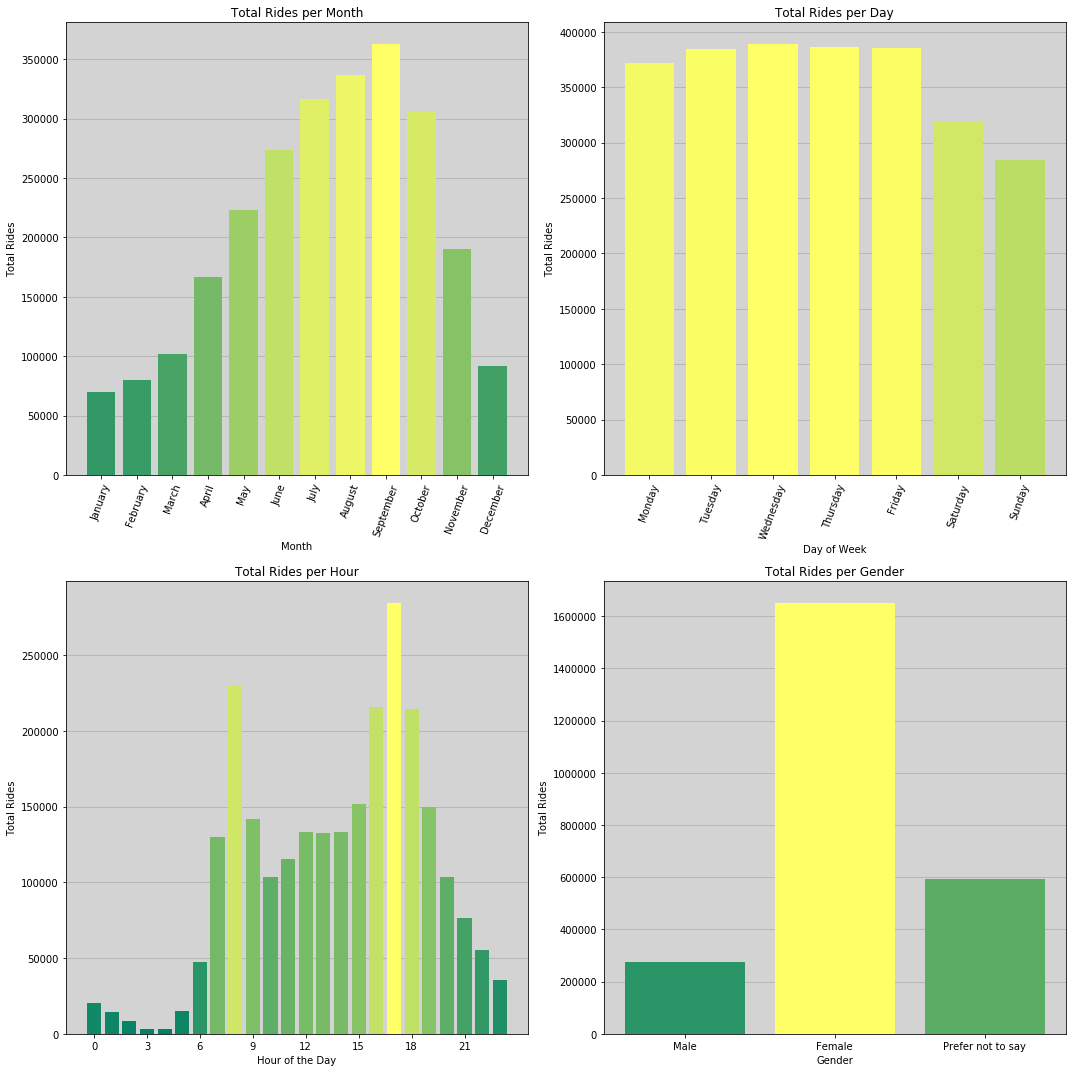

In [24]:
matrix_plot()

In [25]:
def plot_legend(df, sta_nums):
    '''
    Parameters
    ----------
    df: adjusted dataframe
    sta_nums: set of station numbers to be plotted
        
    Returns
    -------
    Nothing.
    Adds consistent stylized legend with station IDs/names to graphs.
    
    '''
    station_ids = get_station_ids(df)
    handles = [mpl.patches.Patch(facecolor = 'k',
                                 edgecolor = 'k',
                                 label = '{}: {}'.format(num,
                                                         station_ids[num]))
               for num in sorted(list(sta_nums))]
    leg = plt.legend(handles = handles,
                     loc = 'upper center',
                     bbox_to_anchor = (0.5, -0.05),
                     shadow = True,
                     ncol = 2,
                     handlelength = 0,
                     handletextpad = 0,
                     fancybox = True)
    for item in leg.legendHandles:
        item.set_visible(False)
    leg.get_frame().set_facecolor('lightblue')

In [26]:
def network_graph(df, n):
    '''
    Parameters
    ----------
    df: adjusted dataframe
    n: (int) number of rides to plot

    Returns
    -------
    network graph of top n routes
    '''
    grouped = df.groupby(['start station id', 'end station id']).count()\
                     ['tripduration']
    grouped = grouped.nlargest(n)
    
    station_numbers = set()
    edge_collection = []
    for i in grouped.index:
        edge_collection.append(i)
        station_numbers.update(i)
    edge_colors = range(len(edge_collection), 0, -1)
    
    G = nx.DiGraph()
    G.add_nodes_from(station_numbers)
    
    pos = nx.layout.circular_layout(G)
    
    plt.figure(figsize = (15, 15))
    nodes = nx.draw_networkx_nodes(G,
                                   pos,
                                   node_size = 5,
                                   node_color = 'black')
    edges = nx.draw_networkx_edges(G,
                                   pos,
                                   node_size = 5,
                                   arrowstyle = '-|>',
                                   arrowsize = 20,
                                   edgelist = edge_collection,
                                   edge_color = edge_colors,
                                   edge_cmap = plt.cm.rainbow,
                                   width = 2)
    
    pc = mpl.collections.PatchCollection(edges,
                                         cmap = plt.cm.rainbow)
    pc.set_array(edge_colors)
    cbar = plt.colorbar(pc,
                        fraction = 0.04,
                        pad = 0.01)
    cbar.ax.tick_params(labelsize = 20) 
    nx.draw_networkx_labels(G,
                            pos,
                            font_size = 20)
    
    ax = plt.gca()
    ax.set_axis_off()
    plot_legend(df, station_numbers)
    plt.axis('equal')
    plt.title('Top {} Blue Bike Routes'.format(n),
              fontdict = {'fontsize': 25,
                          'fontweight': 'bold'},
              pad = -25)
    plt.show()

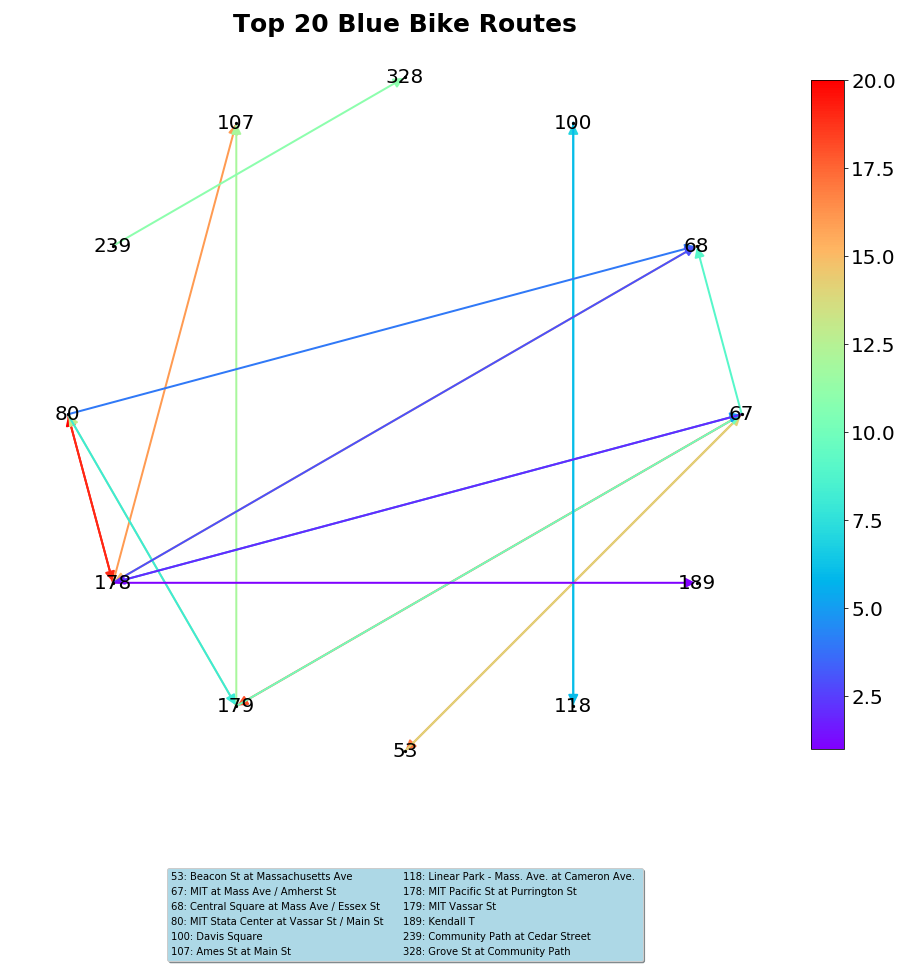

In [27]:
network_graph(df, 20)

In [28]:
def top_trips(df, n):
    '''
    Parameters
    ----------
    df: adjusted dataframe
    n (int): number of top trips to print
        
    Returns
    -------
    Prints top n trips
    
    '''
    station_ids = get_station_ids(df)
    grouped = df.groupby(['start station id', 'end station id']).count()\
                 ['tripduration']
    grouped = grouped.nlargest(n)
    
    edges = []
    for i in grouped.index:
        edges.append(i)
    for num, (i, j) in enumerate(edges, 1):
        print('{}: [{}] {} to [{}] {}'.format(num,
                                              i, station_ids[i],
                                              j, station_ids[j]))

In [29]:
top_trips(df, 20)

1: [178] MIT Pacific St at Purrington St to [80] MIT Stata Center at Vassar St / Main St
2: [80] MIT Stata Center at Vassar St / Main St to [178] MIT Pacific St at Purrington St
3: [67] MIT at Mass Ave / Amherst St to [179] MIT Vassar St
4: [67] MIT at Mass Ave / Amherst St to [53] Beacon St at Massachusetts Ave
5: [178] MIT Pacific St at Purrington St to [107] Ames St at Main St
6: [68] Central Square at Mass Ave / Essex St to [178] MIT Pacific St at Purrington St
7: [53] Beacon St at Massachusetts Ave to [67] MIT at Mass Ave / Amherst St
8: [179] MIT Vassar St to [80] MIT Stata Center at Vassar St / Main St
9: [179] MIT Vassar St to [107] Ames St at Main St
10: [239] Community Path at Cedar Street to [328] Grove St at Community Path
11: [179] MIT Vassar St to [67] MIT at Mass Ave / Amherst St
12: [67] MIT at Mass Ave / Amherst St to [68] Central Square at Mass Ave / Essex St
13: [80] MIT Stata Center at Vassar St / Main St to [179] MIT Vassar St
14: [118] Linear Park - Mass. Ave. at 

In [30]:
def rides_per_dock(df, sta_df, n):
    '''
    Parameters
    ----------
    df: adjusted dataframe
    station_df: dataframe with station names and total docks
    n: (int) number of stations to look at
    start: (bool) whether to look at starting (default) or ending stations

    Returns
    -------
    bar chart of rides per station for top n -ending- stations
    '''
    station_ids = get_station_ids(df)
    
    # Concatenate top starting/ending stations on station ID
    top_df = pd.concat(top_stations(df, -1, False), axis = 1).reset_index()
    top_df = top_df.nlargest(n, 'end station id')
    top_df.columns = ['ID', 'Start rides', 'End rides']
    
    # Station_df uses names instead of numbers, so need to join on names
    top_df['Name'] = top_df['ID'].apply(lambda x: station_ids[x])
    top_df = top_df.join(sta_df.set_index('Name'), on = 'Name')
    
    # Some stations have 0 docks. Delete, but worth investigating separately
    top_df = top_df[top_df['Total docks'] != 0]
    
    # Calculate rides per dock for starting/ending stations
    top_df['Starting rides per dock'] = \
        top_df.apply(lambda x: x['Start rides']/x['Total docks'], axis = 1)
    top_df['Ending rides per dock'] = \
        top_df.apply(lambda x: x['End rides']/x['Total docks'], axis = 1)
    top_df = top_df.sort_values(by = 'Ending rides per dock')
    
    # Pull out useful columns
    top_df = top_df[['ID', 'Ending rides per dock',
                     'Starting rides per dock']].set_index('ID')
    
    # Plot
    top_df.plot(figsize = (10, 10),
                kind = 'barh',
                colormap = 'coolwarm',
                zorder = 2)
    plt.title('Rides per Dock',
              fontdict = {'fontsize': 20},
              pad = -25)
    plt.xlabel('Rides')
    plt.ylabel('Station Number')
    plt.grid(which = 'major', axis = 'x')
    #plt.tick_params(axis = 'both', labelsize = '15')

    # Shade every other station
    for i, j in enumerate(top_df.index):
        if i % 2 == 0:
            plt.axhspan(i - 0.5,
                        i + 0.5,
                        facecolor = 'lightgray',
                        zorder = 1)
    
    # Plot 2 legends
    ax = plt.gca()
    ax.add_artist(plt.legend(loc = 'lower right'))
    station_numbers = set()
    for i in top_df.index:
        station_numbers.add(i)
    plot_legend(df, station_numbers)
    plt.show()

In [31]:
station_df = pd.read_csv('Data/current_bluebikes_stations.csv', skiprows = 1)
station_df.head()

,Number,Name,Latitude,Longitude,District,Public,Total docks
0,A32019,175 N Harvard St,42.363796,-71.129164,Boston,Yes,18
1,S32035,191 Beacon St,42.380323,-71.108786,Somerville,Yes,19
2,S32023,30 Dane St,42.381001,-71.104025,Somerville,Yes,15
3,M32026,359 Broadway - Broadway at Fayette Street,42.370803,-71.104412,Cambridge,Yes,23
4,M32054,699 Mt Auburn St,42.375002,-71.148716,Cambridge,Yes,25


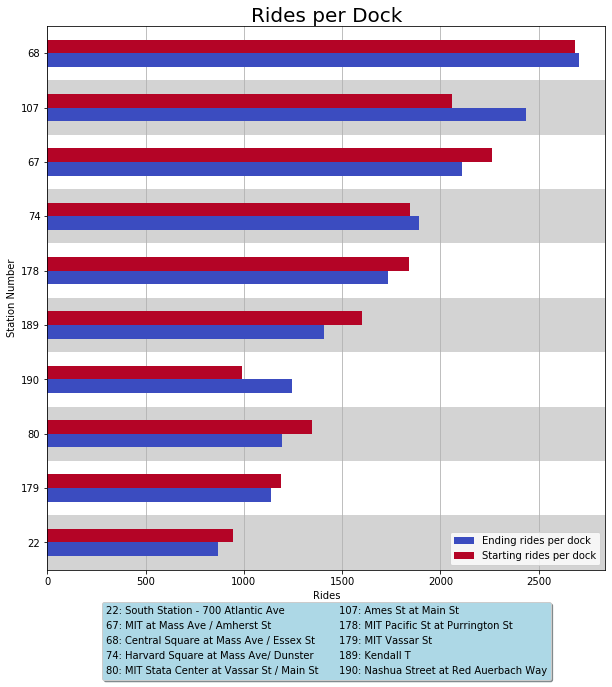

In [32]:
rides_per_dock(df, station_df, 10)